<a href="https://www.kaggle.com/code/kapturovalexander/bank-credit-risk-assessment-model?scriptVersionId=237214236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <span style='color: #DAA06D'>The task is to load the dataset, develop a model to predict debtor default, where default is defined as an overdue period exceeding 90 days. Additionally, I'll plot the ROC and Precision-Recall curves, evaluate the model's performance, and assess the significance of the features.

![british bank](https://blog.sothebysrealty.co.uk/hubfs/Banks%20In%20The%20UK-jpg.jpeg)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-credit-risk-assessment/bank_credit_scoring.xlsx


### <span style="color: #DAA06D">Import libraries</span>

In [2]:
import random
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score, auc

### <span style="color: #DAA06D">Freeze estimations</span>

In [3]:
random.seed(28)
np.random.seed(28)

### <span style="color: #DAA06D">Open data into pandas.dataframe data structure and look on the first 5 rows</span>

In [4]:
warnings.filterwarnings("ignore")
data = pd.read_excel('/kaggle/input/bank-credit-risk-assessment/bank_credit_scoring.xlsx', )
data.head()

,Задолженность,"Просрочка, дни",Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS
0,6063.50,3,7000.0,1983-07-08,Мужской,Среднее специальное,703.07,60,A1,Гомельская область,КОСАКОВКА,АПК,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Женский,Высшее,1693.68,60,B2,NaN,МИНСК,Финансы и страхование,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Женский,Среднее,724.49,60,C2,ГРОДНЕНСКАЯ,ЁДКИ,Медицина и здравоохранение,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Женский,Среднее специальное,1045.84,60,A3,МИНСКАЯ,ФАНИПОЛЬ,Государственное управление,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Женский,Высшее,1092.65,60,B3,NaN,Минск,Медицина и здравоохранение,0.63,425193,NaN,0,NaN,2


### <span style="color: #DAA06D">Save the data in csv format</span>

In [5]:
data.to_csv(path_or_buf='bank_credit_scoring.csv', index=False)
print('File has been created successfully!')

File has been created successfully!


#### Let's check our saved data in .csv format

In [6]:
df = pd.read_csv('bank_credit_scoring.csv')
df.head()

,Задолженность,"Просрочка, дни",Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS
0,6063.50,3,7000.0,1983-07-08,Мужской,Среднее специальное,703.07,60,A1,Гомельская область,КОСАКОВКА,АПК,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Женский,Высшее,1693.68,60,B2,NaN,МИНСК,Финансы и страхование,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Женский,Среднее,724.49,60,C2,ГРОДНЕНСКАЯ,ЁДКИ,Медицина и здравоохранение,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Женский,Среднее специальное,1045.84,60,A3,МИНСКАЯ,ФАНИПОЛЬ,Государственное управление,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Женский,Высшее,1092.65,60,B3,NaN,Минск,Медицина и здравоохранение,0.63,425193,NaN,0,NaN,2


# <span style="color: #DAA06D">EDA</span>

In [7]:
data.shape

(18420, 18)

#### There are 18 features and 18420 observations (borrowers)

In [8]:
# Concise summary of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18420 entries, 0 to 18419
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Задолженность              18420 non-null  float64       
 1   Просрочка, дни             18420 non-null  int64         
 2   Первоначльный лимит        18420 non-null  float64       
 3   BIRTHDATE                  18420 non-null  datetime64[ns]
 4   SEX                        18420 non-null  object        
 5   EDU                        18420 non-null  object        
 6   INCOME                     18420 non-null  float64       
 7   TERM                       18420 non-null  int64         
 8   Рейтинг кредитной истории  17488 non-null  object        
 9   LV_AREA                    16297 non-null  object        
 10  LV_SETTLEMENTNAME          18374 non-null  object        
 11  INDUSTRYNAME               18420 non-null  object        
 12  PDN 

In [9]:
numerical_features = [
    'Задолженность', 
    'Первоначльный лимит',    
    'INCOME', 
    'TERM', 
    'PDN', 
    'CLIENTID',
    'SCORINGMARK', 
    'UNDERAGECHILDRENCOUNT', 
    'VELCOMSCORING',
    'FAMILYSTATUS'
]

categorical_features = ['SEX', 'EDU', 'Рейтинг кредитной истории', 'LV_AREA', 'LV_SETTLEMENTNAME', 'INDUSTRYNAME']

#### We grouped features with types int/float and object

In [10]:
# Detect missing values
data.isna().sum()

Задолженность                   0
Просрочка, дни                  0
Первоначльный лимит             0
BIRTHDATE                       0
SEX                             0
EDU                             0
INCOME                          0
TERM                            0
Рейтинг кредитной истории     932
LV_AREA                      2123
LV_SETTLEMENTNAME              46
INDUSTRYNAME                    0
PDN                             0
CLIENTID                        0
SCORINGMARK                  1634
UNDERAGECHILDRENCOUNT           0
VELCOMSCORING                9531
FAMILYSTATUS                    0
dtype: int64

#### There are 5 features with empty (NaN) values. We have to fill them

In [11]:
# Percent of missed data
values = np.product(data.shape)  # All values in the data
nans = data.isnull().sum().sum()  # NaN values in the data
print(f'Percent of missed values is: {nans / values * 100:.2f}%')

Percent of missed values is: 4.30%


#### Is this values are missing because they weren't recorded or because they don't exist? I will fegure out it

In [12]:
target = data[data.columns[1]]  # 'Просрочка, дни' feature
target.sort_values(ascending=False)

3930     491
3725     491
3997     491
8837     460
920      460
        ... 
6588       0
6589       0
6590       0
6591       0
18419      0
Name: Просрочка, дни, Length: 18420, dtype: int64

#### There are borrowers who overdued their loans

In [13]:
overdue = target[target > 90].count()
print(f'Number of borrowers who overdued loans: {overdue}')
print(f'Share of overdued credits is: {overdue / data.shape[0] * 100:.2f}%')

Number of borrowers who overdued loans: 755
Share of overdued credits is: 4.10%


In [14]:
data['OVERDUE'] = data['Просрочка, дни'] > 90
data.loc[920:922]

,Задолженность,"Просрочка, дни",Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS,OVERDUE
920,500.00,460,500.0,1992-05-12,Женский,Среднее специальное,835.41,60,B3,ВИТЕБСКАЯ,ЛЕЩИЛОВО,АПК,0.18,818372,NaN,3,NaN,1,True
921,14184.94,0,20000.0,1986-10-14,Мужской,Высшее,2677.90,36,NaN,Гродненская область,ОСТРОВЕЦ,Строительство,0.30,813372,107.0,0,NaN,2,False
922,9214.02,0,10800.0,2001-01-01,Мужской,Неоконченное высшее,1234.05,60,C1,г. Минск,Минск,Торговля,0.40,857603,170.0,0,NaN,2,False


#### We added new feature and it is filled with True/False values. We are going to use [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to transform values into 0s and 1s

In [15]:
label_encoders = {}  # Create Hash table for all features and their transformations

In [16]:
le = LabelEncoder()
le.fit([False, True])

data['OVERDUE'] = le.transform(data['OVERDUE'])
label_encoders['OVERDUE'] = le

In [17]:
data.loc[920:922]

,Задолженность,"Просрочка, дни",Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS,OVERDUE
920,500.00,460,500.0,1992-05-12,Женский,Среднее специальное,835.41,60,B3,ВИТЕБСКАЯ,ЛЕЩИЛОВО,АПК,0.18,818372,NaN,3,NaN,1,1
921,14184.94,0,20000.0,1986-10-14,Мужской,Высшее,2677.90,36,NaN,Гродненская область,ОСТРОВЕЦ,Строительство,0.30,813372,107.0,0,NaN,2,0
922,9214.02,0,10800.0,2001-01-01,Мужской,Неоконченное высшее,1234.05,60,C1,г. Минск,Минск,Торговля,0.40,857603,170.0,0,NaN,2,0


#### We used LabelEncoder correctly and switch False to 0 and True to 1 for OVERDUE feature

| Column                  | Description                                              |
|-------------------------|----------------------------------------------------------|
| Задолженность           | Current credit debt amount                               |
| Просрочка, дни          | Days past due                                            |
| Первоначльный лимит     | Initial credit limit                                     |
| BIRTHDATE               | Client’s birth date                                      |
| SEX                     | Gender (Male/Female)                                     |
| EDU                     | Education level                                          |
| INCOME                  | Client’s income                                          |
| TERM                    | Credit term (in months)                                  |
| Рейтинг кредитной истории | Credit history rating (categorical)                    |
| LV_AREA                 | Region of residence                                      |
| LV_SETTLEMENTNAME       | Settlement name                                          |
| INDUSTRYNAME            | Employment industry                                      |
| PDN                     | Debt burden ratio                                        |
| CLIENTID                | Client ID (unique identifier)                            |
| SCORINGMARK             | Credit scoring mark                                      |
| UNDERAGECHILDRENCOUNT   | Number of underage children                              |
| VELCOMSCORING           | Scoring value from another model                         |
| FAMILYSTATUS            | Marital status                                           |

## <span style="color: #DAA06D">Let's look deeper on each feature of the dataset</span>

#### Visualize some features' distribution

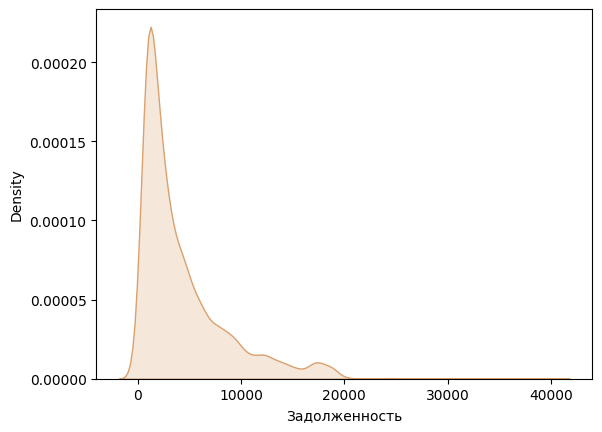

In [18]:
sns.kdeplot(data=data, x='Задолженность', color='#DAA06D', fill=True);

#### We see right-skewed distribution in <span style="color: #DAA06D">Задолженность</span> feature. The graph shows a sharp peak near zero with a long tail extending to higher values. This indicates that most individuals have relatively low credit debt, while a smaller number have significantly higher debt amounts.

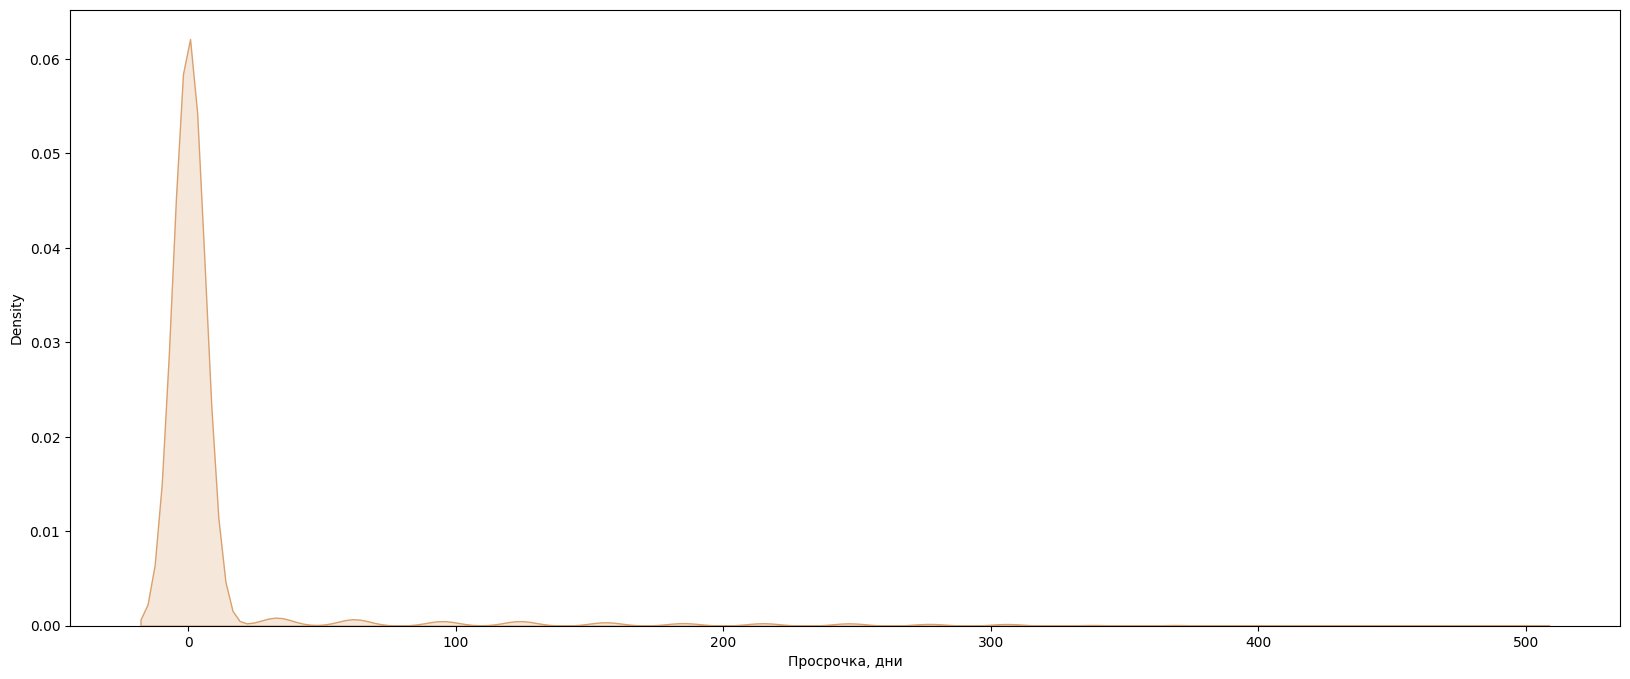

In [19]:
plt.figure(figsize=(20, 8))
sns.kdeplot(data=data, x='Просрочка, дни', color='#DAA06D', fill=True);

#### Most clients (about 96%) haven't got big overdue (>90 days)

(90.0, 491.0)

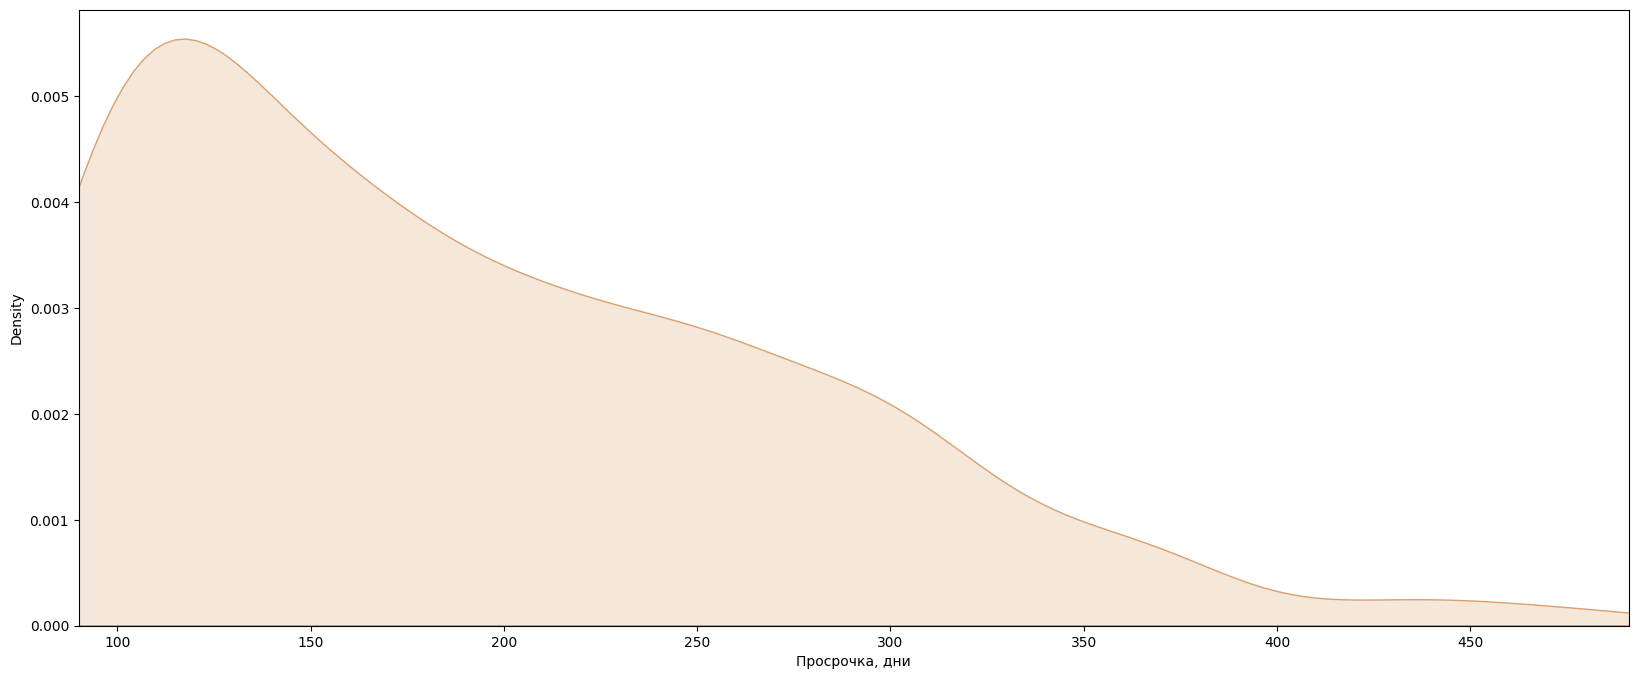

In [20]:
plt.figure(figsize=(20, 8))
sns.kdeplot(data=data.loc[data['Просрочка, дни'] > 90], x='Просрочка, дни', color='#DAA06D', fill=True);
plt.xlim((90, data['Просрочка, дни'].max()))

![banks](https://media.licdn.com/dms/image/v2/D4E12AQEMLzYOwhcTIg/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1660297878015?e=2147483647&v=beta&t=t-SIW0q0v0uVB0ZRS6Z2R5LFtsT3gV3bUe0SrOCgyZo)

#### The graph above demonstrates only those borrowers who overdued credit payment for more than 90 days. <span style="color: orange">Просрочка, дни</span> right-skew distribution shows that most of them overdued 90 days not for long period

#### We are going to remove <span style="color: orange">**Просрочка, дни**</span> feature cause this is initial target and we won't know these values in new values

In [21]:
data.drop('Просрочка, дни', axis=1, inplace=True)

#### <span style="color: orange">BIRTHDAY</span> feature we will transform to store just an age

In [22]:
data['BIRTHDATE'] = datetime.now().year - data['BIRTHDATE'].dt.year - 1

In [23]:
data['BIRTHDATE']  # Now this feature has int32 dtype

0        41
1        37
2        58
3        52
4        27
         ..
18415    25
18416    31
18417    22
18418    21
18419    30
Name: BIRTHDATE, Length: 18420, dtype: int32

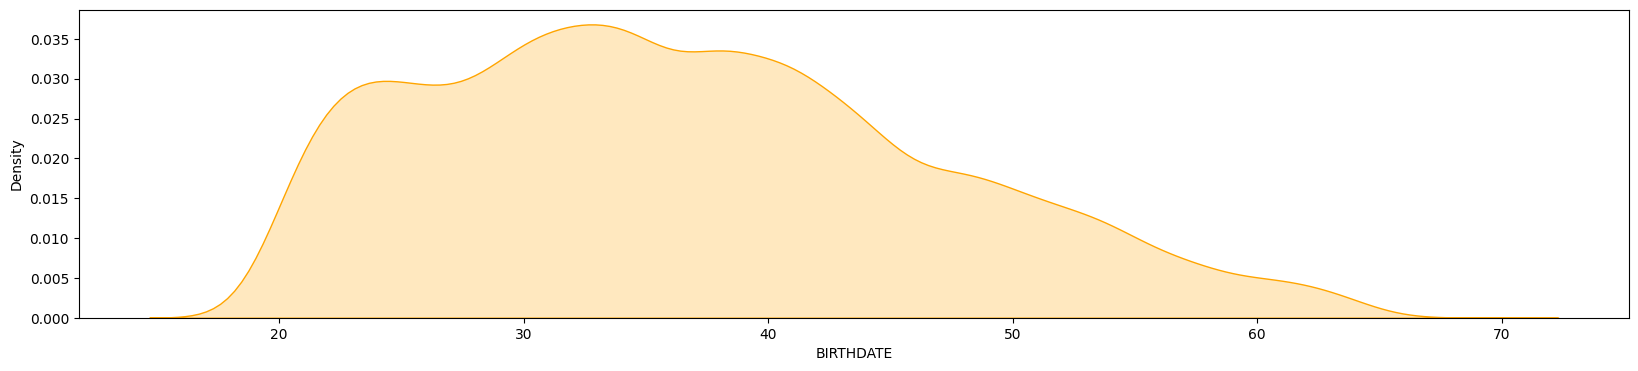

In [24]:
plt.figure(figsize=(20, 4))
sns.kdeplot(data=data, x='BIRTHDATE', color='orange', fill=True);

In [25]:
numerical_features.append('BIRTHDATE')

#### The graph above shows that most credits are taken by people who are 20-55 years old. This category needs more than it could afford. Flats and new cars are too expensive compared to salaries

In [26]:
data['SEX'].value_counts()

SEX
Мужской    11249
Женский     7171
Name: count, dtype: int64

In [27]:
data['SEX'].value_counts() / data.shape[0]

SEX
Мужской    0.610695
Женский    0.389305
Name: count, dtype: float64

#### About 61% of borrowers are men and 39% are women 

In [28]:
data['SEX'].loc[data['OVERDUE'] == 1].value_counts()

SEX
Мужской    436
Женский    319
Name: count, dtype: int64

#### Above integer amount of borrowers with credit overdue

#### Now let's look on the <span style="color: orange">EDU</span> feature

In [29]:
data['EDU'].value_counts()

EDU
Среднее специальное    9196
Высшее                 6140
Среднее                2519
Неоконченное высшее     555
**Послевузовское         10
Name: count, dtype: int64

#### According to Belarusian statistics only 35% of citizens have higher degree and info above just accept it, but I still don't understand what '**<span style="color: orange">Послевузовское</span>**' mean. I'm gonna to transform it to <span style="color: orange">'Высшее'</span>

In [30]:
data.loc[data['EDU'] == '**Послевузовское', 'EDU'] = 'Высшее'
data['EDU'].value_counts()

EDU
Среднее специальное    9196
Высшее                 6150
Среднее                2519
Неоконченное высшее     555
Name: count, dtype: int64

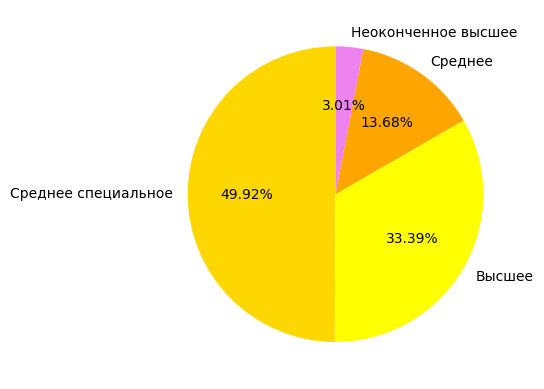

In [31]:
edu = data['EDU'].value_counts()
colors = ['gold', 'yellow', 'orange', 'violet', 'purple', 'red', 'brown']
plt.pie(x=edu, labels=edu.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(edu)]);

In [32]:
data[data['INCOME'] > 10000]

,Задолженность,Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS,OVERDUE
2928,1425.00,3000.0,45,Мужской,Высшее,10132.29,36,A3,Минская,Пигасово,Иное,0.34,137757,287.0,3,NaN,1,0
4039,1276.18,2500.0,46,Мужской,Неоконченное высшее,14337.16,36,B2,NaN,Минск,Информационные технологии,0.08,432771,NaN,1,NaN,1,0
4136,1531.47,3000.0,53,Мужской,Высшее,28437.50,36,B3,NaN,Минск,Иное,0.03,97834,267.0,0,NaN,1,0
4217,10514.46,15000.0,41,Мужской,Высшее,14241.04,60,A1,NaN,Минск,Информационные технологии,0.22,405511,NaN,3,NaN,1,0
4480,3463.43,6000.0,31,Мужской,Высшее,14838.18,24,B2,Минская область,Клецк,Информационные технологии,0.05,431852,314.0,1,NaN,1,0
13210,9318.55,10000.0,38,Мужской,Высшее,29942.82,60,A1,Минская область,ЖОДИНО,Строительство,0.06,473808,270.0,2,934.0,1,0
13264,9804.43,12000.0,32,Мужской,Среднее специальное,10796.93,24,B2,Витебская область,КУБЛИЧИ,Строительство,0.15,577271,181.0,0,-2.0,2,0
15022,18864.07,20000.0,34,Мужской,Высшее,12570.24,60,B2,Минская область,Ратомка,Финансы и страхование,0.27,181785,276.0,0,851.0,2,0


#### There are only 8 borrowers with monthly salary > 10000 belarusian rubles (3.5 rubles = 1 USD)

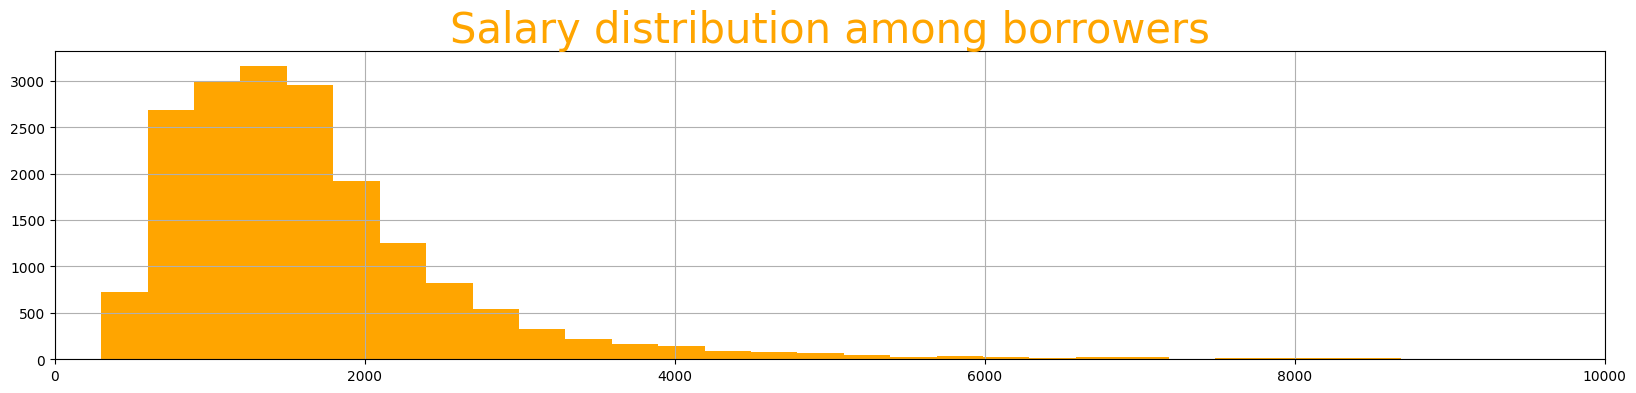

In [33]:
plt.figure(figsize=(20, 4))
data['INCOME'].hist(bins=100, color='orange')
plt.xlim((0, 10000))
plt.title(label='Salary distribution among borrowers', color='orange', fontsize=30);

#### Looks like Lognormal distribution. **PowerTransformer** should help with this

In [34]:
data['Рейтинг кредитной истории'].value_counts().sort_index()

Рейтинг кредитной истории
-1       4
A1     777
A2     640
A3     996
B1    1335
B2    1701
B3    2154
C1    2080
C2    2012
C3    2006
D1    1387
D2    1060
D3     869
E1     200
E2     123
E3     144
Name: count, dtype: int64

#### -1 means that there is no ranking for credit right now? <span style="color: orange">Рейтинг кредитной истории</span> like <span style="color: orange">EDU</span> are ranking features and later should be mapping in correct order

In [35]:
data.loc[data['Рейтинг кредитной истории'] == '-1']

,Задолженность,Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS,OVERDUE
3257,1021.13,2000.0,24,Мужской,Высшее,1056.07,36,-1,ВИТЕБСКАЯ,НОВОСЕЛКИ,Наука и образование,0.08,544748,NaN,0,NaN,2,0
3404,988.79,2000.0,22,Женский,Среднее,1283.34,36,-1,NaN,МИНСК,Производство,0.07,775360,NaN,0,NaN,2,0
5628,773.37,1000.0,21,Мужской,Среднее специальное,823.39,36,-1,ГРОДНЕНСКАЯ ОБЛАСТЬ,НОВОГРУДОК,Производство,0.05,549474,52.0,0,NaN,2,1
5860,1595.26,3000.0,61,Мужской,Среднее специальное,514.48,36,-1,МИНСКАЯ,ХОЛХОЛИЦА,АПК,0.25,798407,NaN,0,NaN,1,1


#### These 4 people have really low income (lower then 400 $ per month) and two of them overdued a loan for a huge time

In [36]:
data['LV_AREA'].value_counts()

LV_AREA
г. Минск               4290
Минская область        2408
Витебская область      1154
Гомельская область     1025
Брестская область      1021
Могилевская область     876
МИНСКАЯ                 733
ВИТЕБСКАЯ               702
ГОМЕЛЬСКАЯ              680
Гродненская область     674
БРЕСТСКАЯ               632
ГРОДНЕНСКАЯ             524
МОГИЛЕВСКАЯ             420
МИНСКАЯ ОБЛАСТЬ         263
МОГИЛЁВСКАЯ             258
ВИТЕБСКАЯ ОБЛАСТЬ       122
БРЕСТСКАЯ ОБЛАСТЬ       106
ГОМЕЛЬСКАЯ ОБЛАСТЬ      105
МОГИЛЕВСКАЯ ОБЛАСТЬ      91
Минская                  79
ГРОДНЕНСКАЯ ОБЛАСТЬ      72
Гомельская               14
Витебская                13
Могилевская              12
Брестская                11
МИНСК                     4
Гродненская               4
Г. МИНСК                  2
ГОМЕЛЬСКАЯ ОБЛ            1
МОГИЛЕВСК                 1
Name: count, dtype: int64

#### Indexes above have many repetitions. Let's fix it

In [37]:
def transform_LV_AREA_values(city: str) -> str:
    """
    Replace repetitions and variations in city or region titles with normalized names.

    Args:
        city (str): Belarusian cities or regions where borrowers live.

    Returns:
        str: Normalized city or region names.
    """
    match city:
        case 'г. Минск' | 'МИНСК' | 'Г. МИНСК':
            return 'Минск'
        case 'Минская область' | 'МИНСКАЯ' | 'Минская' | 'МИНСКАЯ ОБЛАСТЬ':
            return 'Минская область'
        case 'Витебская область' | 'ВИТЕБСКАЯ' | 'ВИТЕБСКАЯ ОБЛАСТЬ' | 'Витебская':
            return 'Витебская область'
        case 'Гомельская область' | 'ГОМЕЛЬСКАЯ' | 'ГОМЕЛЬСКАЯ ОБЛАСТЬ' | 'Гомельская' | 'ГОМЕЛЬСКАЯ ОБЛ':
            return 'Гомельская область'
        case 'Брестская область' | 'БРЕСТСКАЯ' | 'БРЕСТСКАЯ ОБЛАСТЬ' | 'Брестская':
            return 'Брестская область'
        case 'Могилевская область' | 'МОГИЛЕВСКАЯ' | 'МОГИЛЁВСКАЯ' | 'МОГИЛЕВСКАЯ ОБЛАСТЬ' | 'Могилевская' | 'МОГИЛЕВСК':
            return 'Могилевская область'
        case 'Гродненская область' | 'ГРОДНЕНСКАЯ' | 'ГРОДНЕНСКАЯ ОБЛАСТЬ' | 'Гродненская':
            return 'Гродненская область'
        case _:
            return city

#### We could used .replace() method, regular expression .lower() method or removing 'г.' where exists but I decided to implement this using match-case method

In [38]:
data['LV_AREA'] = data['LV_AREA'].apply(func=transform_LV_AREA_values)
data['LV_AREA'].value_counts()

LV_AREA
Минск                  4296
Минская область        3483
Витебская область      1991
Гомельская область     1825
Брестская область      1770
Могилевская область    1658
Гродненская область    1274
Name: count, dtype: int64

#### Now <span style="color: orange">LV_AREA</span> feature looks better

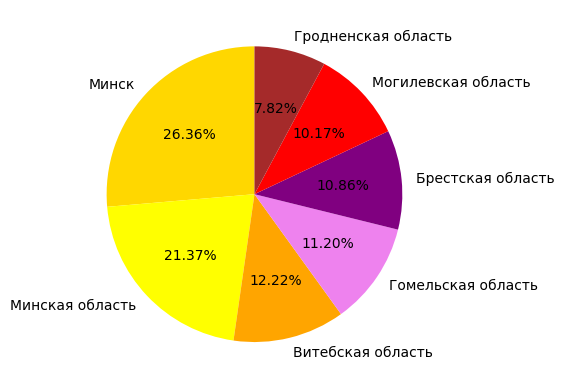

In [39]:
area = data['LV_AREA'].value_counts()
plt.pie(x=area, labels=area.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(area)]);

#### About 47.7 % of borrowers are from city Minsk and Minsk region

In [40]:
data.head()

,Задолженность,Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS,OVERDUE
0,6063.50,7000.0,41,Мужской,Среднее специальное,703.07,60,A1,Гомельская область,КОСАКОВКА,АПК,0.98,919517,233.0,0,NaN,1,0
1,3765.04,5000.0,37,Женский,Высшее,1693.68,60,B2,NaN,МИНСК,Финансы и страхование,0.17,539353,NaN,1,NaN,1,0
2,2067.66,2650.0,58,Женский,Среднее,724.49,60,C2,Гродненская область,ЁДКИ,Медицина и здравоохранение,0.40,818913,NaN,0,NaN,2,0
3,2370.39,3000.0,52,Женский,Среднее специальное,1045.84,60,A3,Минская область,ФАНИПОЛЬ,Государственное управление,0.29,691598,216.0,0,NaN,2,0
4,2280.55,3000.0,27,Женский,Высшее,1092.65,60,B3,NaN,Минск,Медицина и здравоохранение,0.63,425193,NaN,0,NaN,2,0


In [41]:
data['LV_SETTLEMENTNAME'].value_counts().index

Index(['МИНСК', 'Минск', 'МОГИЛЕВ', 'ГОМЕЛЬ', 'ВИТЕБСК', 'БРЕСТ', 'ГРОДНО',
       'БОРИСОВ', 'БОБРУЙСК', 'БАРАНОВИЧИ',
       ...
       'ВАЛЯНЧИЦЫ', 'МАЛАЯ БЕРЕСТОВИЦА', 'ПРЕСНАКИ', 'СТОЛОВИЧИ', 'БУЛАВКИ',
       'СТОЛБУНОВИЧИ', 'Курганы', 'ПОГРАНИЧНАЯ', 'ГОРЕЛЕЦ', 'Жалы'],
      dtype='object', name='LV_SETTLEMENTNAME', length=2229)

In [42]:
data['LV_SETTLEMENTNAME'].value_counts()[:20]

LV_SETTLEMENTNAME
МИНСК         3775
Минск         1268
МОГИЛЕВ        663
ГОМЕЛЬ         642
ВИТЕБСК        589
БРЕСТ          445
ГРОДНО         430
БОРИСОВ        245
БОБРУЙСК       217
БАРАНОВИЧИ     208
СОЛИГОРСК      181
ПОЛОЦК         159
ОРША           154
МОЛОДЕЧНО      142
РЕЧИЦА         142
ЖОДИНО         128
ЖЛОБИН         124
Могилев        117
Гомель         109
Брест           96
Name: count, dtype: int64

#### We see some duplicates in cities names: some has title and .upper() case title but these are same titles. Let's fix it!

In [43]:
data['LV_SETTLEMENTNAME'] = data['LV_SETTLEMENTNAME'].str.capitalize()
data['LV_SETTLEMENTNAME'].value_counts()[:20]

LV_SETTLEMENTNAME
Минск         5043
Могилев        780
Гомель         751
Витебск        676
Брест          541
Гродно         505
Борисов        290
Барановичи     248
Бобруйск       239
Солигорск      211
Молодечно      169
Полоцк         159
Речица         157
Жодино         156
Орша           155
Жлобин         144
Новополоцк     120
Лида           110
Мозырь         109
Пинск          105
Name: count, dtype: int64

In [44]:
# Gather top-10 cities (indexes and values)
top_10_cities = data['LV_SETTLEMENTNAME'].value_counts().index[:10]
filtered_data = data[data['LV_SETTLEMENTNAME'].isin(top_10_cities)]

#### Let's show overdue distribution among top-10 cities

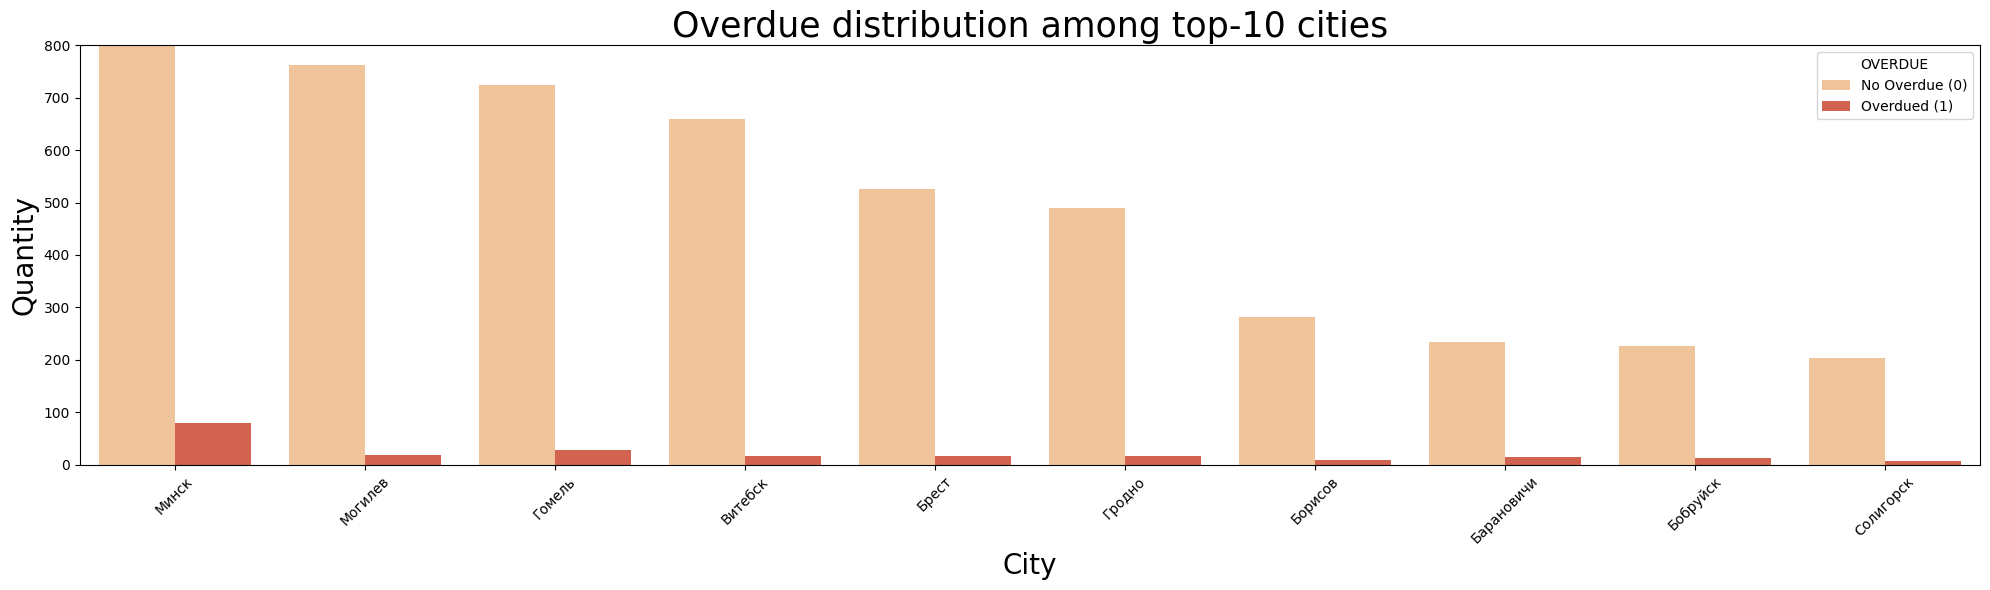

In [45]:
plt.figure(figsize=(20, 6))
sns.countplot(data=filtered_data, x='LV_SETTLEMENTNAME', hue='OVERDUE', palette='OrRd', order=top_10_cities)
plt.title('Overdue distribution among top-10 cities', fontsize=25)
plt.xlabel('City', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.ylim((0, 800))
plt.xticks(rotation=45)
plt.legend(title='OVERDUE', labels=['No Overdue (0)', 'Overdued (1)'])
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

#### I think that <span style="color: orange">LV_SETTLEMENTNAME</span> feature is informative for our task and I guess we will include it in the model

In [46]:
data['INDUSTRYNAME'].value_counts()

INDUSTRYNAME
Производство                  4323
Торговля                      3100
АПК                           1858
Услуги населению              1166
Строительство                 1154
Наука и образование           1150
Транспорт/перевозки           1077
МВД/МЧС/МО                    1053
Медицина и здравоохранение     981
Финансы и страхование          801
Государственное управление     526
Информационные технологии      510
Иное                           390
Культура и искусство           121
Спорт и туризм                 120
Пенсионер                       90
Name: count, dtype: int64

#### Above we see that all borrowers split into 16 categories

In [47]:
sum(data['CLIENTID'].value_counts() > 1)

2118

#### There are 2118 clients who took more than 1 credit

#### <span style="color: orange">CLIENTID</span> is not useless feature, it will help make new feature via feature engineering

In [48]:
client_id_repeat = data['CLIENTID'].value_counts()
credit_repeat = client_id_repeat[client_id_repeat > 1].index
credit_repeat[:10]  # We received id of repeated credits

Index([766243, 592876, 796297, 912277, 580149, 894140, 698694, 338401, 807693,
       908208],
      dtype='int64', name='CLIENTID')

In [49]:
data['TOOK_ANOTHER_CREDIT'] = data['CLIENTID'].isin(credit_repeat).astype(int)
data['TOOK_ANOTHER_CREDIT'].value_counts()

TOOK_ANOTHER_CREDIT
0    12713
1     5707
Name: count, dtype: int64

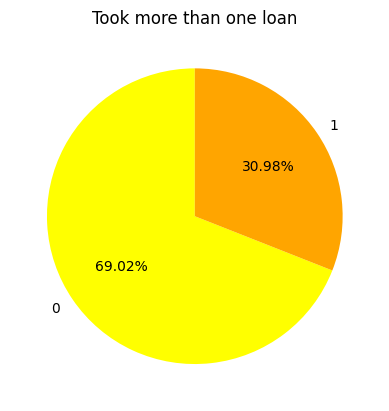

In [50]:
another = data['TOOK_ANOTHER_CREDIT'].value_counts()
plt.pie(x=another, labels=another.index, autopct='%1.2f%%', startangle=90, colors=colors[1 : len(another) + 1])
plt.title('Took more than one loan');

## Well, it means that 18420 it's not a number of clients. There are 12713 clients who has taken one loan and 2118 who has taken more than one. It means that those borrowers who has taken more than 1 loan took in average 2.7 loans! There is 14831 clients, not 18420!

In [51]:
data['UNDERAGECHILDRENCOUNT'].value_counts()

UNDERAGECHILDRENCOUNT
0    10559
1     4714
2     2426
3      721
Name: count, dtype: int64

#### I don't actually know what this <span style="color: orange">UNDERAGECHILDRENCOUNT</span> means but I guess that it is a number of children below 18 years old

#### I guess that <span style="color: orange">VELCOMSCORING</span> is scoring which was calculated on the data received from Velcome (A1) telecom-company 

In [52]:
data['FAMILYSTATUS'].value_counts()

FAMILYSTATUS
1    9241
2    9172
3       6
4       1
Name: count, dtype: int64

#### There are only 4 groups of families among borrowers, but groups 3 and 4 are very seldom

## <span style="color: orange">Handling Missing Values</span>

In [53]:
data.isnull().sum()

Задолженность                   0
Первоначльный лимит             0
BIRTHDATE                       0
SEX                             0
EDU                             0
INCOME                          0
TERM                            0
Рейтинг кредитной истории     932
LV_AREA                      2123
LV_SETTLEMENTNAME              46
INDUSTRYNAME                    0
PDN                             0
CLIENTID                        0
SCORINGMARK                  1634
UNDERAGECHILDRENCOUNT           0
VELCOMSCORING                9531
FAMILYSTATUS                    0
OVERDUE                         0
TOOK_ANOTHER_CREDIT             0
dtype: int64

#### There are features with missing values. Now we have to understand whick of them empty because info was lost or empty because it shouldn't be filled with something

In [54]:
data['Рейтинг кредитной истории']

0         A1
1         B2
2         C2
3         A3
4         B3
        ... 
18415     B1
18416    NaN
18417     C2
18418     C1
18419     C1
Name: Рейтинг кредитной истории, Length: 18420, dtype: object

In [55]:
data['Рейтинг кредитной истории'].mode()[0]

'B3'

#### B3 rank is most frequent but if we input B3 in each empty value we can confuse our model. After correlation analysis we will know what do but for initial I will fill NaN with 'without rating' for this feature

In [56]:
data['Рейтинг кредитной истории'].fillna(value='without rating', inplace=True)

In [57]:
data['LV_AREA'].value_counts()  # We don't know living area for each of 9th borrowers

LV_AREA
Минск                  4296
Минская область        3483
Витебская область      1991
Гомельская область     1825
Брестская область      1770
Могилевская область    1658
Гродненская область    1274
Name: count, dtype: int64

In [58]:
data[['LV_AREA', 'LV_SETTLEMENTNAME']] = data[['LV_AREA', 'LV_SETTLEMENTNAME']].fillna(value='unknown')

#### <span style="color: orange">VELCOMSCORING</span> that lost about 50% of info, so let's drop it

In [59]:
print(data['VELCOMSCORING'].sort_values().unique()[:20])

[ -2. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 119.]


#### We can fill <span style="color: orange">VELCOMSCORING</span> NaN values with 0 because there is no such values which are used but let's use **KNNImputer** in numerical features

In [60]:
data.drop('VELCOMSCORING', axis=1, inplace=True)

In [61]:
%%time
# data['VELCOMSCORING'] = data['VELCOMSCORING'].fillna(value=0)

imputer = KNNImputer(n_neighbors=2)
data[['SCORINGMARK']] = imputer.fit_transform(data[['SCORINGMARK']])

CPU times: user 1.94 s, sys: 357 ms, total: 2.3 s
Wall time: 1.64 s


In [62]:
data['SCORINGMARK'].sort_values().unique()[:30]

array([-108.,  -90.,  -75.,  -74.,  -69.,  -61.,  -60.,  -49.,  -46.,
        -40.,  -39.,  -36.,  -16.,  -15.,   -8.,   -7.,   -3.,   -2.,
         -1.,    2.,    4.,    6.,    9.,   13.,   15.,   18.,   21.,
         22.,   25.,   26.])

In [63]:
data.isnull().sum()

Задолженность                0
Первоначльный лимит          0
BIRTHDATE                    0
SEX                          0
EDU                          0
INCOME                       0
TERM                         0
Рейтинг кредитной истории    0
LV_AREA                      0
LV_SETTLEMENTNAME            0
INDUSTRYNAME                 0
PDN                          0
CLIENTID                     0
SCORINGMARK                  0
UNDERAGECHILDRENCOUNT        0
FAMILYSTATUS                 0
OVERDUE                      0
TOOK_ANOTHER_CREDIT          0
dtype: int64

## <span style="color: orange">Statistical analysis</span>

In [64]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Задолженность,18420.0,4318.769750,4336.432353,0.0,1287.9000,2675.670000,5785.87,40000.00
Первоначльный лимит,18420.0,5127.834256,4879.201691,180.0,1550.0000,3200.000000,6912.50,40000.00
BIRTHDATE,18420.0,36.629859,10.238431,19.0,29.0000,36.000000,43.00,68.00
INCOME,18420.0,1664.840782,1048.813447,0.0,1021.6925,1460.175000,1980.46,29942.82
TERM,18420.0,52.301737,13.378788,23.0,36.0000,60.000000,60.00,60.00
PDN,18420.0,0.290288,0.144359,0.0,0.1900,0.300000,0.39,1.21
CLIENTID,18420.0,822624.452443,196685.329933,12898.0,719347.7500,908364.500000,962136.00,1061453.00
SCORINGMARK,18420.0,186.432622,64.370409,-108.0,138.0000,186.432622,229.00,416.00
UNDERAGECHILDRENCOUNT,18420.0,0.636754,0.854167,0.0,0.0000,0.000000,1.00,3.00
FAMILYSTATUS,18420.0,1.498751,0.500988,1.0,1.0000,1.000000,2.00,4.00


In [65]:
data.describe(include=object).T

,count,unique,top,freq
SEX,18420,2,Мужской,11249
EDU,18420,4,Среднее специальное,9196
Рейтинг кредитной истории,18420,17,B3,2154
LV_AREA,18420,8,Минск,4296
LV_SETTLEMENTNAME,18420,1998,Минск,5043
INDUSTRYNAME,18420,16,Производство,4323


#### Encode labels for categorical features

In [66]:
for col in categorical_features:
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

data.head()

,Задолженность,Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,FAMILYSTATUS,OVERDUE,TOOK_ANOTHER_CREDIT
0,6063.50,7000.0,41,1,3,703.07,60,1,3,803,0,0.98,919517,233.000000,0,1,0,0
1,3765.04,5000.0,37,0,0,1693.68,60,5,0,1080,15,0.17,539353,186.432622,1,1,0,1
2,2067.66,2650.0,58,0,2,724.49,60,8,4,1,6,0.40,818913,186.432622,0,2,0,0
3,2370.39,3000.0,52,0,3,1045.84,60,3,6,1833,1,0.29,691598,216.000000,0,2,0,0
4,2280.55,3000.0,27,0,0,1092.65,60,6,0,1080,6,0.63,425193,186.432622,0,2,0,0


#### Our hash-map with labels encoders

In [67]:
label_encoders

{'OVERDUE': LabelEncoder(),
 'SEX': LabelEncoder(),
 'EDU': LabelEncoder(),
 'Рейтинг кредитной истории': LabelEncoder(),
 'LV_AREA': LabelEncoder(),
 'LV_SETTLEMENTNAME': LabelEncoder(),
 'INDUSTRYNAME': LabelEncoder()}

#### Visualize feature importance (Better use SHAP)

In [68]:
X = data.drop('OVERDUE', axis=1)
# X = pd.get_dummies(X, drop_first=True, dtype=int)  This will create huge number of new features (don't use in this case!)
y = data['OVERDUE']

CPU times: user 3.4 s, sys: 3.3 ms, total: 3.41 s
Wall time: 3.41 s


<Axes: >

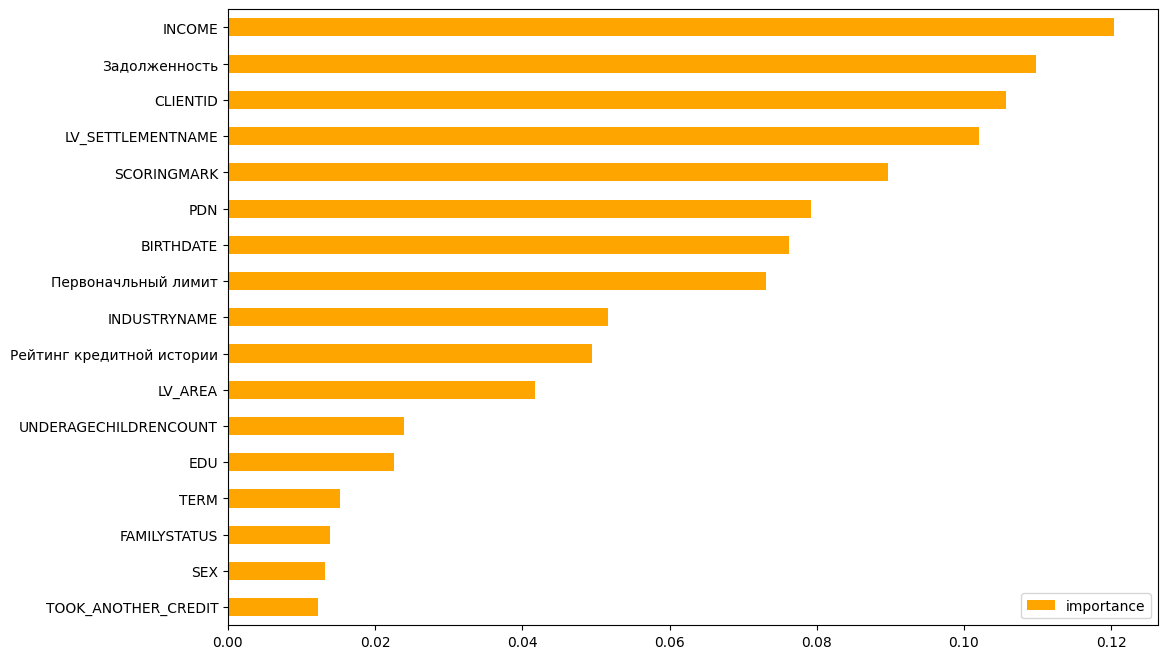

In [69]:
%%time
best_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=28,  
)
    
best_rf.fit(X, y)
importance = best_rf.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='orange');

#### Build heatmap to visualize feature correlation

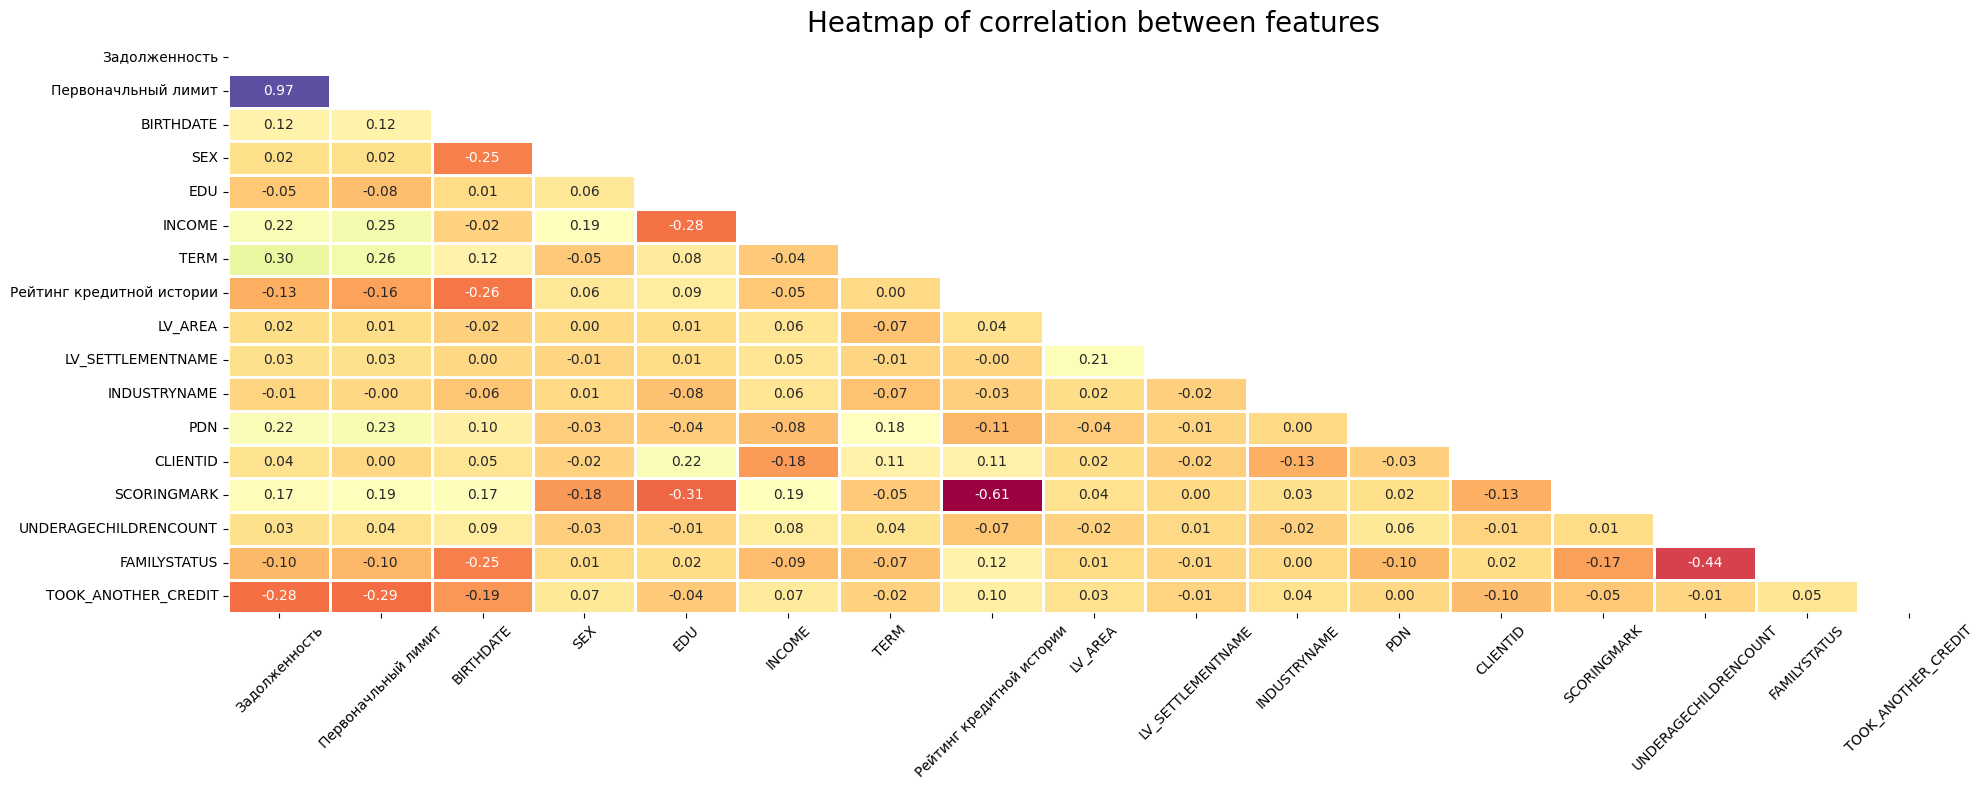

In [70]:
plt.figure(figsize=(20, 8))
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.title('Heatmap of correlation between features', fontsize=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Two features <span style="color: orange">Задолженность</span> and <span style="color: orange">Первоначльный лимит</span> has huge multicorrelation. We have to drop one of them

In [71]:
x = add_constant(data.drop('OVERDUE', axis=1))
vif = pd.DataFrame()
vif['Feature'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vif)

                      Feature         VIF
0                       const  155.799456
1               Задолженность   17.371251
2         Первоначльный лимит   17.570488
3                   BIRTHDATE    1.262685
4                         SEX    1.187554
5                         EDU    1.250750
6                      INCOME    1.326499
7                        TERM    1.194649
8   Рейтинг кредитной истории    1.781381
9                     LV_AREA    1.064981
10          LV_SETTLEMENTNAME    1.050146
11               INDUSTRYNAME    1.029952
12                        PDN    1.137451
13                   CLIENTID    1.128184
14                SCORINGMARK    1.992731
15      UNDERAGECHILDRENCOUNT    1.263891
16               FAMILYSTATUS    1.360388
17        TOOK_ANOTHER_CREDIT    1.186066


#### As VIF in features <span style="color: orange">Задолженность</span> and <span style="color: orange">Первоначльный лимит</span> is more than 10 then we have huge multicorrelation and have to remove on of them

#### <span style="color: orange">Первоначльный лимит</span> is less important feature, so we drop it

In [72]:
X.drop('Первоначльный лимит', axis=1, inplace=True)

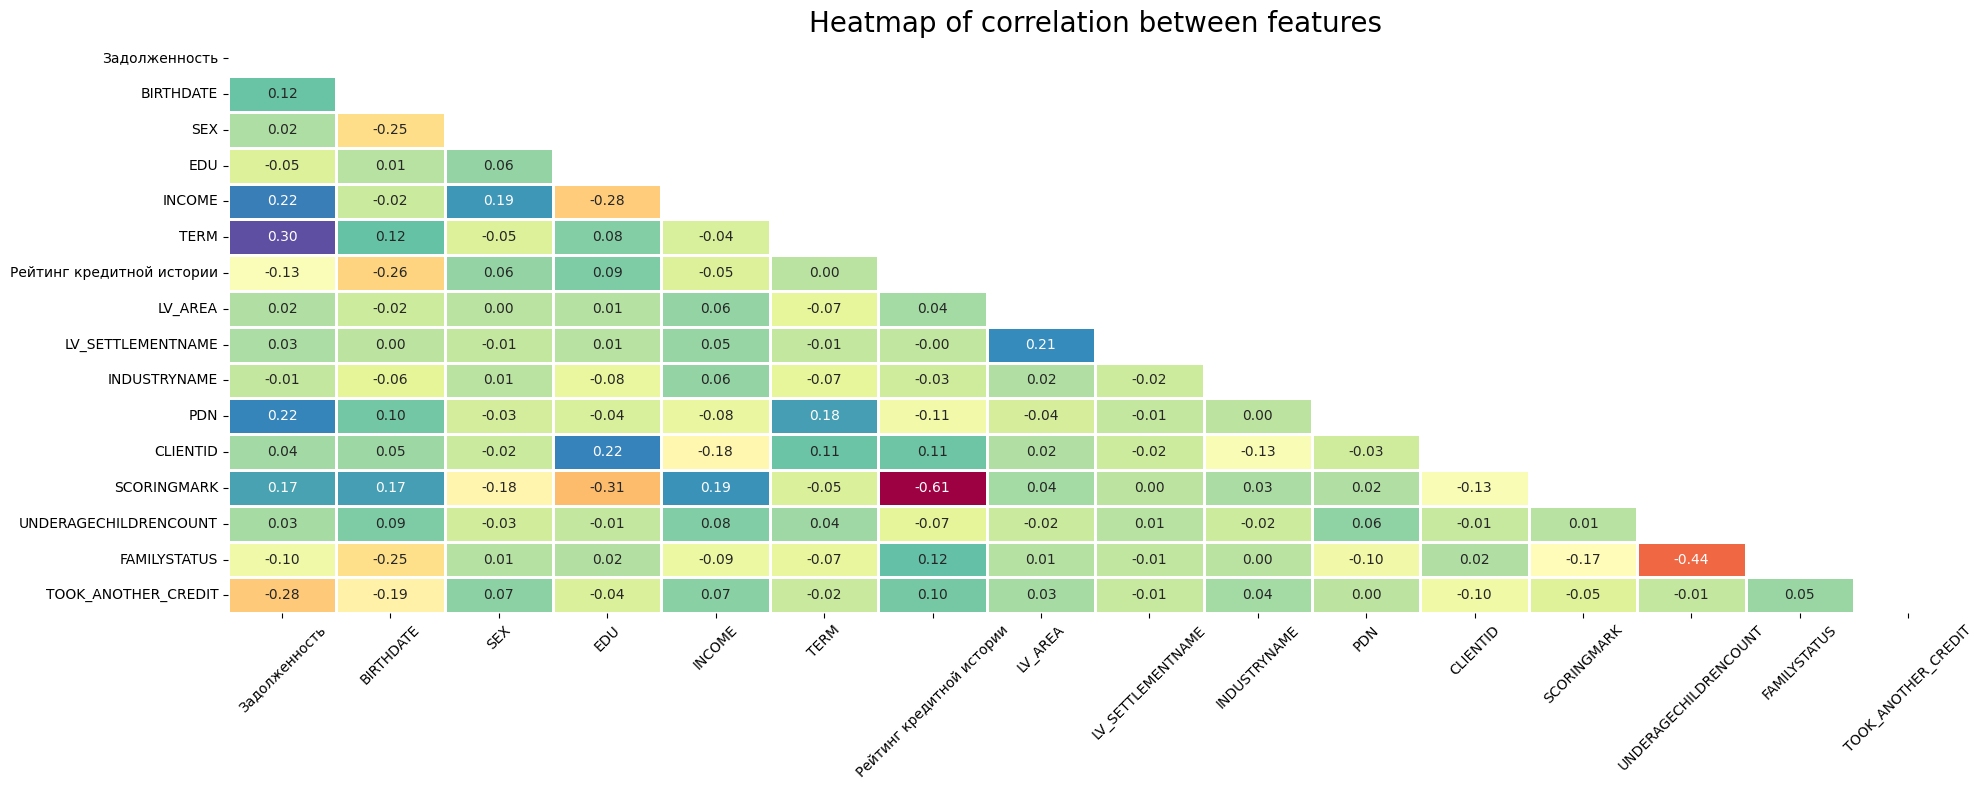

In [73]:
plt.figure(figsize=(20, 8))
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.title('Heatmap of correlation between features', fontsize=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
x = add_constant(data.drop('OVERDUE', axis=1))
vif = pd.DataFrame()
vif['Feature'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vif)

                      Feature         VIF
0                       const  155.799456
1               Задолженность   17.371251
2         Первоначльный лимит   17.570488
3                   BIRTHDATE    1.262685
4                         SEX    1.187554
5                         EDU    1.250750
6                      INCOME    1.326499
7                        TERM    1.194649
8   Рейтинг кредитной истории    1.781381
9                     LV_AREA    1.064981
10          LV_SETTLEMENTNAME    1.050146
11               INDUSTRYNAME    1.029952
12                        PDN    1.137451
13                   CLIENTID    1.128184
14                SCORINGMARK    1.992731
15      UNDERAGECHILDRENCOUNT    1.263891
16               FAMILYSTATUS    1.360388
17        TOOK_ANOTHER_CREDIT    1.186066


#### So we defeated multicorrelation in our data!

#### Split the data in train and test data. In real better to split in train/valid/test but this time split into 2 datasets

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [76]:
columns = ['Задолженность', 'BIRTHDATE', 'SEX', 'EDU', 'INCOME', 'TERM',
       'Рейтинг кредитной истории', 'LV_AREA', 'LV_SETTLEMENTNAME',
       'INDUSTRYNAME', 'PDN', 'CLIENTID', 'SCORINGMARK',
       'UNDERAGECHILDRENCOUNT', 'FAMILYSTATUS',
       'TOOK_ANOTHER_CREDIT']

#### Standardize numeric features

In [77]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Train Logistic Regression model. I will not use SMOTE to tackle with inbalance but I will add 'class_weight' in LogReg

In [78]:
log_reg = LogisticRegression(class_weight='balanced', random_state=28, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

#### I could tune hyperparameters via Optuna but I'm out of time now

In [79]:
# Model coefficients and intercept
coefficients = log_reg.coef_
intercept = log_reg.intercept_

coeff_df = pd.DataFrame(coefficients.T, columns=['Coefficient'], index=columns)
print(f'Intercept: {intercept[0]}')
coeff_df

Intercept: -0.5536697866420397


,Coefficient
Задолженность,0.174346
BIRTHDATE,0.001605
SEX,0.049537
EDU,0.226233
INCOME,-0.839224
TERM,0.074589
Рейтинг кредитной истории,-0.058176
LV_AREA,0.051991
LV_SETTLEMENTNAME,-0.022361
INDUSTRYNAME,-0.364086


#### Build classification report

In [80]:
classification_report_output = classification_report(y_test, y_pred, zero_division=0)
print(classification_report_output)

              precision    recall  f1-score   support

           0       0.98      0.66      0.79      3533
           1       0.08      0.74      0.15       151

    accuracy                           0.66      3684
   macro avg       0.53      0.70      0.47      3684
weighted avg       0.95      0.66      0.76      3684



#### Draw our plots

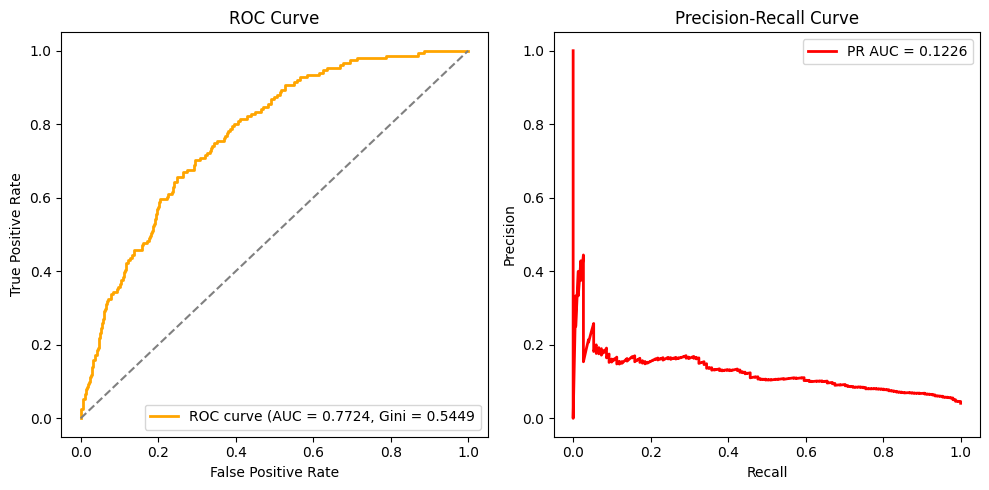

In [81]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

gini = 2 * roc_auc - 1

# Plotting ROC Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f}, Gini = {gini:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Plotting PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='red', lw=2, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

#### ROC-AUC (0.7724) - the model has a good discriminatory division into classes (default and non-default). The Gini coefficient (0.5449) confirms that the model is significantly better than random guessing.
#### PR-AUC (0.1231) - area under the Precision-Recall request curve, this indicates possible complex models with prediction of random events (defaults).